## 가상환경설정
    아나콘다 가상환경 설정하기
  - conda create -n med_chatbot python=3.9
  - conda activate  med_chatbot
  - pip install torch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0 (cpu만 사용할때)
  - pip install python-mecab-ko
  - pip install sentence-transformers
  - pip install pandas
  - pip install matplotlib
  - pip install numpy==1.26.4 (제일 중요!(numpy가 2.0.1로 깔려있지만, 원활한 함수 사용을 위해 1.26.4로 다운그레이드 해줘야함))

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
from sentence_transformers import util
from mecab import MeCab

import json
from glob import glob

c:\Users\KOREAVC\anaconda3\envs\med_chatbot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## json 데이터 불러와 데이터 프레임 만들기
 1. glob으로 해당 폴더 모든 json 파일경로를 list로 불러옴
 2. json.load를 이용해 질문, 답변, 의도를 각각 리스트에 모두 담는다
 3. 질문, 답변, 의도에 대한 데이터 프레임을 만들고 concat으로 하나의 데이터프레임으로 합친다

In [7]:
def all_data(path1, path2):
    question_path = path1
    answer_path = path2

    return glob(question_path + '/*'), glob(answer_path + '/*')

In [8]:
disease_q_path, disease_a_path = all_data('./training/라벨링데이터/질문/' , './training/라벨링데이터/답변/') # 경로 입력

In [9]:
disease_q_path # q_data : 의도별 폴더

['./training/라벨링데이터/질문\\알츠하이머병',
 './training/라벨링데이터/질문\\알코올성 치매',
 './training/라벨링데이터/질문\\우울증',
 './training/라벨링데이터/질문\\치매']

In [10]:
q_list = []
a_list = []
i_list = []
for intention_q_path, intention_a_path in zip(disease_q_path, disease_a_path):
    intention_q_folders, intention_a_folders = glob(intention_q_path + '/*'), glob(intention_a_path + '/*')
    
    for q_intention, a_intention  in zip(intention_q_folders, intention_a_folders):
        q_json_files = glob(q_intention + '/*')
        a_json_files = glob(a_intention + '/*')
        
        # print(q_intention, len(q_json_files), a_intention, len(a_json_files))
        # print(min([len(q_json_files), len(a_json_files)]))
        
        for idx in range(min([len(q_json_files), len(a_json_files)])):
            with open(q_json_files[idx], 'r', encoding='utf-8') as file:
                q_json_data = json.load(file)
                q_list.append(q_json_data['question'])
                i_list.append(q_json_data['intention'])
            with open(a_json_files[idx], 'r', encoding='utf-8') as file:
                a_json_data = json.load(file)
                sentence = ""
                for key in a_json_data['answer'].keys():
                    sentence += a_json_data['answer'][key]
                a_list.append(sentence)

In [11]:
q_df = pd.DataFrame(q_list)
i_df = pd.DataFrame(i_list)
a_df = pd.DataFrame(a_list)

In [12]:
df = pd.concat((q_df, i_df, a_df), axis=1)
df.columns = ['question', 'intention', 'answer']

In [2]:
df = pd.read_csv('dementia_fix.csv', index_col=0)
df.columns = ['question', 'intention', 'answer']

In [3]:
df

,question,intention,answer
0,"알츠하이머병의 원인으로 매일 소주를 섭취하는 것이 언급되고 있는데, 이에 대한 근거...",원인,"알츠하이머병의 정확한 원인은 아직 밝혀지지 않았지만, 연구들이 알츠하이머병의 발병 ..."
1,알츠하이머병이라는 질병은 유전적 영향을 받는 것인가요?,원인,알츠하이머병은 현재까지 완전한 원인이 밝혀지지 않았습니다.알츠하이머병은 아직 완전히...
2,알츠하이머병의 발생 원인에 대한 연구나 발견이 진행 중인가요?,원인,"알츠하이머병은 치매를 일으키는 가장 흔한 퇴행성 뇌질환으로, 1907년 독일 의사 ..."
3,알츠하이머병의 발병과 관련하여 뇌의 노화로 인한 증상과 원인을 알려주세요.,원인,알츠하이머병은 현재까지 그 발병 원인에 대한 완벽한 해명은 아직 이루어지지 않았습니...
4,알츠하이머병의 원인과 관련된 연구 결과가 있을까요? 알려주세요.,원인,"알츠하이머병은 복잡한 질환으로, 아직도 원인이 완전히 밝혀진 것은 아닙니다. 그러나..."
...,...,...,...
6618,치매 치료에는 어떤 운동이나 작업이 효과적일까요?,치료,"치매는 노인들에게 주로 발생하는 뇌질환으로, 원인과 치료 방법은 아직 완전히 밝혀진..."
6619,치매 치료의 결과와 과정을 상세히 설명해주세요. 치매 치료의 효과는 어떻게 나타날까요?,치료,"치매는 일상 생활을 수행하는 능력을 심각하게 손상시키는 질환으로, 후천성 치매와 노..."
6620,치매를 치료하기 위해 어떤 치료 방법들이 효과적일까요?,치료,"치매는 노화로 인해 기억력과 지능을 점차적으로 잃는 질병으로, 알츠하이머병이 주요한..."
6621,치매 치료를 위해 어떤 약물이 사용될 수 있을까요?,치료,알츠하이머병은 뇌에 변화가 생겨서 인지 기능에 장애가 생기는 신경퇴행성 질환입니다....


In [14]:
df.to_csv("dementia_fix.csv", sep=',', encoding='utf-8')

In [15]:
# df = df.sample(frac=1).reset_index(drop=True)
# df.to_csv("dementia_shuffle.csv", sep=',', encoding='utf-8')

In [16]:
# def all_data(path1, path2):
#     question_path = path1
#     answer_path = path2

#     return glob(question_path + '/*/*.json'), glob(answer_path + '/*/*.json')

In [17]:
# q_data, a_data = all_data('./dementia/training/원천데이터/질문/치매', './dementia/training/원천데이터/답변/치매') # 경로 입력

In [18]:
# # 치매 데이터 개수 확인 (질문, 답변)
# len(q_data), len(a_data)

In [19]:
# with open(q_data[1000], 'r', encoding='utf-8') as file:
#     json_data = json.load(file)
#     print(json_data)

In [20]:
# q_list = []
# for i in range(len(q_data)):
#     with open(q_data[i], 'r', encoding='utf-8') as file:
#         json_data = json.load(file)
#         q_list.append(json_data['question'])

In [21]:
# a_list = []
# for i in range(len(q_data)):
#     with open(a_data[i], 'r', encoding='utf-8') as file:
#         json_data = json.load(file)
#         sentence = ""
#         for key in json_data['answer']:
#             sentence += json_data['answer'][key]
#         a_list.append(sentence)

In [22]:
# i_list=[]
# for i in range(len(q_data)):
#     with open(q_data[i],'r',encoding='utf-8') as file:
#         json_data=json.load(file)
#         sentence = ""
#         sentence += json_data['intention']
#         i_list.append(sentence)

In [23]:
# df = pd.read_csv('dementia_shuffle.csv', encoding='utf-8', index_col=0)

In [24]:
# # 데이터 프레임 만들기
# q_df = pd.DataFrame(q_list) # 질문 데이터 프레임
# a_df = pd.DataFrame(a_list) # 답변 데이터 프레임
# i_df = pd.DataFrame(i_list) # 의도 데이터 프레임
# qa_df = pd.concat((q_df, a_df), axis=1) # 질문-의도 데이터 프레임
# qa_df.columns=['question', 'answer']
# qi_df = pd.concat((q_df, i_df), axis=1) # 질문-답변 데이터 프레임
# qi_df.columns=['question', 'intention']
# df = pd.concat((q_df, i_df, a_df), axis=1) # 질문-의도-답변 데이터 프레임
# df.columns=['question', 'intention', 'answer']

In [25]:
# # csv 파일로 저장
# df.to_csv("dementia_qia.csv", sep=',') #질문, 의도, 답변 포함
# qa_df.to_csv("dementia_qa.csv", sep=',') #질문, 답변
# qi_df.to_csv("dementia_qi.csv", sep=',') #질문, 의도 -> 나중에 의도 분류 모델에 활용할수도 ?

In [4]:
q_data = df['question']
a_data = df['answer']

In [5]:
q_data

0       알츠하이머병의 원인으로 매일 소주를 섭취하는 것이 언급되고 있는데, 이에 대한 근거...
1                          알츠하이머병이라는 질병은 유전적 영향을 받는 것인가요?
2                      알츠하이머병의 발생 원인에 대한 연구나 발견이 진행 중인가요?
3               알츠하이머병의 발병과 관련하여 뇌의 노화로 인한 증상과 원인을 알려주세요.
4                     알츠하이머병의 원인과 관련된 연구 결과가 있을까요? 알려주세요.
                              ...                        
6618                          치매 치료에는 어떤 운동이나 작업이 효과적일까요?
6619     치매 치료의 결과와 과정을 상세히 설명해주세요. 치매 치료의 효과는 어떻게 나타날까요?
6620                       치매를 치료하기 위해 어떤 치료 방법들이 효과적일까요?
6621                         치매 치료를 위해 어떤 약물이 사용될 수 있을까요?
6622                          치매 치료를 위해 어떤 전문가와 협력해야 할까요?
Name: question, Length: 6623, dtype: object

In [28]:
# 형태소 분석 불러오기
from mecab import MeCab
m = MeCab()

# 각 질문마다 형태소 분석을 통해 질문당 몇 개의 단어 토큰이 들어갔는지 count리스트에 담음
count = []
for q in q_data:
        count_num = len(m.morphs(q))
        count.append(count_num)
len(count)

6623

In [29]:
question = df['question']
answer = df['answer']
intention = df['intention']
df['answer']

0       알츠하이머병의 정확한 원인은 아직 밝혀지지 않았지만, 연구들이 알츠하이머병의 발병 ...
1       알츠하이머병은 현재까지 완전한 원인이 밝혀지지 않았습니다.알츠하이머병은 아직 완전히...
2       알츠하이머병은 치매를 일으키는 가장 흔한 퇴행성 뇌질환으로, 1907년 독일 의사 ...
3       알츠하이머병은 현재까지 그 발병 원인에 대한 완벽한 해명은 아직 이루어지지 않았습니...
4       알츠하이머병은 복잡한 질환으로, 아직도 원인이 완전히 밝혀진 것은 아닙니다. 그러나...
                              ...                        
6618    치매는 노인들에게 주로 발생하는 뇌질환으로, 원인과 치료 방법은 아직 완전히 밝혀진...
6619    치매는 일상 생활을 수행하는 능력을 심각하게 손상시키는 질환으로, 후천성 치매와 노...
6620    치매는 노화로 인해 기억력과 지능을 점차적으로 잃는 질병으로, 알츠하이머병이 주요한...
6621    알츠하이머병은 뇌에 변화가 생겨서 인지 기능에 장애가 생기는 신경퇴행성 질환입니다....
6622    치매는 현재까지 완전한 치료가 불가능한 치매입니다. 치매는 다양한 원인에 의해 발생...
Name: answer, Length: 6623, dtype: object

In [30]:
# 각 질문마다 형태소 분석을 통해 답변당 몇 개의 단어 토큰이 들어갔는지 count1 리스트에 담음

count1 = []
for a in a_data:
    count_num = len(m.morphs(a))
    count1.append(count_num)
len(count1)

6623

[ 6. 16. 19. 22. 25. 30.]


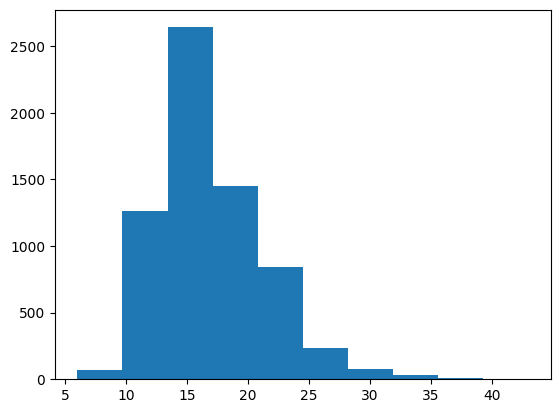

In [31]:
# 질문에 사용된 단어 개수

import matplotlib.pyplot as plt

plt.hist(count)
point_6 = np.percentile(count, q=[0, 50, 75, 90, 95, 99]) # 상위 0%, 50%, 75%, 90%, 95%, 99% 구간으로 나눠서 분포 그리기
print(point_6)

[ 66. 185. 216. 251. 277. 350.]


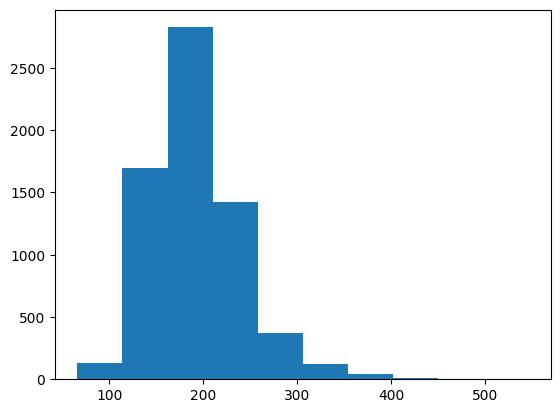

In [32]:
# 답변에 사용된 단어 개수 ()

plt.hist(count1)
point1_6 = np.percentile(count1, q=[0, 50, 75, 90, 95, 99]) # 상위 0%, 50%, 75%, 90%, 95%, 99% 구간으로 나눠서 분포 그리기
print(point1_6)

In [33]:
import re

# 한글, 영어, 숫자, 공백, ?!.,을 제외한 나머지 문자 제거
korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'

# 패턴 컴파일
normalizer = re.compile(korean_pattern)
normalizer

re.compile(r'[^ ?,.!A-Za-z0-9가-힣+]', re.UNICODE)

In [34]:
# 불용어 처리 (그런데 이미 불용어 처리된 데이터라 변화가 거의 없음)
print(f'수정 전: {question[20]}')
print(f'수정 후: {normalizer.sub("", question[20])}')
print(f'수정 전: {answer[20]}')
print(f'수정 후: {normalizer.sub("", answer[20])}')

수정 전: 알츠하이머병의 원인이 30대에서 더 쉽게 찾아볼 수 있는 이유가 있나요?
수정 후: 알츠하이머병의 원인이 30대에서 더 쉽게 찾아볼 수 있는 이유가 있나요?
수정 전: 알츠하이머병은 노화된 단백질이 뇌세포를 파괴하는 퇴행성 신경 질환입니다. 이 질환은 노화에 따른 뇌신경세포의 죽음으로 인해 발생하며, 정확한 원인은 알려져 있지 않습니다. 초기 증상은 경미한 기억 장애부터 언어 장애, 행동 변화 등으로 나타납니다.알츠하이머병은 점진적인 기억력 감퇴와 언어 장애, 실행증(실어증), 시공간능력 장애, 행동 및 정신행동 증상 등을 보입니다. 진행되면서 불안, 우울, 난폭성 등과 같은 정신증상도 나타날 수 있습니다.알츠하이머병은 치료가 불가능한 질환이지만, 조기에 진단을 받고 적절한 치료와 관리를 시작하는 것이 중요합니다. 이를 통해 삶의 질을 향상시키고 증상을 완화시킬 수 있습니다.
수정 후: 알츠하이머병은 노화된 단백질이 뇌세포를 파괴하는 퇴행성 신경 질환입니다. 이 질환은 노화에 따른 뇌신경세포의 죽음으로 인해 발생하며, 정확한 원인은 알려져 있지 않습니다. 초기 증상은 경미한 기억 장애부터 언어 장애, 행동 변화 등으로 나타납니다.알츠하이머병은 점진적인 기억력 감퇴와 언어 장애, 실행증실어증, 시공간능력 장애, 행동 및 정신행동 증상 등을 보입니다. 진행되면서 불안, 우울, 난폭성 등과 같은 정신증상도 나타날 수 있습니다.알츠하이머병은 치료가 불가능한 질환이지만, 조기에 진단을 받고 적절한 치료와 관리를 시작하는 것이 중요합니다. 이를 통해 삶의 질을 향상시키고 증상을 완화시킬 수 있습니다.


In [35]:
def normalize(sentence):
    return normalizer.sub("", sentence)

normalize(question[20])

'알츠하이머병의 원인이 30대에서 더 쉽게 찾아볼 수 있는 이유가 있나요?'

In [36]:
# 형태소 분석 돌려보기
mecab = MeCab()
mecab.morphs(normalize(question[20]))

['알츠하이머병',
 '의',
 '원인',
 '이',
 '30',
 '대',
 '에서',
 '더',
 '쉽',
 '게',
 '찾아볼',
 '수',
 '있',
 '는',
 '이유',
 '가',
 '있',
 '나요',
 '?']

In [37]:
# 한글 전처리를 함수화
def clean_text(sentence, mecab):
    sentence = normalize(sentence)
    sentence = mecab.morphs(sentence)
    sentence = ' '.join(sentence)
    sentence = sentence.lower()
    return sentence

In [38]:
# 한글
clean_text(question[20], mecab)
clean_text(answer[20], mecab)

'알츠하이머병 은 노화 된 단백질 이 뇌세포 를 파괴 하 는 퇴행 성 신경 질환 입니다 . 이 질환 은 노화 에 따른 뇌신경 세포 의 죽음 으로 인해 발생 하 며 , 정확 한 원인 은 알려져 있 지 않 습니다 . 초기 증상 은 경미 한 기억 장애 부터 언어 장애 , 행동 변화 등 으로 나타납니다 . 알츠하이머병 은 점진 적 인 기억력 감퇴 와 언어 장애 , 실행증 실어증 , 시공간 능력 장애 , 행동 및 정신 행동 증상 등 을 보입니다 . 진행 되 면서 불안 , 우울 , 난폭 성 등 과 같 은 정신 증상 도 나타날 수 있 습니다 . 알츠하이머병 은 치료 가 불 가능 한 질환 이 지만 , 조기 에 진단 을 받 고 적절 한 치료 와 관리 를 시작 하 는 것 이 중요 합니다 . 이 를 통해 삶 의 질 을 향상 시키 고 증상 을 완화 시킬 수 있 습니다 .'

In [39]:
# 질문과 답변을 형태소 분석한 결과를 각각 리스트에 모두 담음
questions = [clean_text(sent, mecab) for sent in question.values[:len(question)]]
answers = [clean_text(sent, mecab) for sent in answer.values[:len(question)]]

In [40]:
questions[:5]

['알츠하이머병 의 원인 으로 매일 소주 를 섭취 하 는 것 이 언급 되 고 있 는데 , 이 에 대한 근거 가 있 는지 알려 주 세요 .',
 '알츠하이머병 이 라는 질병 은 유전 적 영향 을 받 는 것 인가요 ?',
 '알츠하이머병 의 발생 원인 에 대한 연구 나 발견 이 진행 중 인가요 ?',
 '알츠하이머병 의 발병 과 관련 하 여 뇌 의 노화 로 인한 증상 과 원인 을 알려 주 세요 .',
 '알츠하이머병 의 원인 과 관련 된 연구 결과 가 있 을까요 ? 알려 주 세요 .']

In [41]:
answers[:5]

['알츠하이머병 의 정확 한 원인 은 아직 밝혀 지 지 않 았 지만 , 연구 들 이 알츠하이머병 의 발병 기전 에 대해 논의 하 고 있 습니다 . 일부 연구 에 따르 면 , 유전 적 인 요소 와 뇌 의 기능 손상 이 관련 되 어 있 다고 알려져 있 습니다 . 알츠하이머병 은 아밀로이드 베타 단백질 과 타우 단백질 의 과도 한 생 성 , 뇌 세포 의 비 정상 적 인 활동 , 뇌 조직 의 변화 로 인해 발생 하 는 것 으로 생각 되 고 있 습니다 . 이러 한 변화 가 알츠하이머병 의 발병 위험 을 증가 시키 고 , 병 의 진행 을 가속 화 시킨다는 것 입니다 . 알츠하이머병 의 발병 과 관련 된 위험 요소 에 대해서 는 더 많 은 연구 와 조사 가 필요 합니다 . 더 많 은 연구 와 자료 수집 을 통해 알츠하이머병 에 대한 더 많 은 이해 와 예방 방법 이 개발 될 것 으로 기대 됩니다 .',
 '알츠하이머병 은 현재 까지 완전 한 원인 이 밝혀 지 지 않 았 습니다 . 알츠하이머병 은 아직 완전히 이해 되 지 않 았 지만 , 연구 결과 에 따르 면 유전 적 인 요소 와 다양 한 환경 적 인 요인 이 이 질환 을 일으키 는 역할 을 한다고 알려져 있 습니다 . 특히 , 아밀로이드 베타 단백질 의 비 정상 적 인 축적 이 알츠하이머병 과 관련 이 있 는 것 으로 알려져 있 습니다 . 이 외 에 도 나이 , 노화 , 고 혈압 , 당뇨병 , 그리고 흡연 등 과 같 은 다른 요인 들 도 알츠하이머병 발병 과 연관 성 이 있 을 수 있 습니다 . 더 많 은 연구 와 조사 를 통해 알츠하이머병 의 원인 을 파악 하 고 예방 방법 을 개발 할 필요 가 있 습니다 .',
 '알츠하이머병 은 치매 를 일으키 는 가장 흔한 퇴행 성 뇌 질환 으로 , 1907 년 독일 의사 알로이스 알츠하이머 에 의해 처음 으로 보 고 되 었 습니다 . 이 질환 의 원인 에 대해서 는 현재 까지 명확 한 답 은 없 으나 , 치매 발생 의 위험 요소 와 관련 하 여 몇 가지 위험 요인 이 알려져 있 

## seq2seq 모델
 1. 질문과 답변 내용을 모두 형태소 분석하여 큰 단어사전을 만듬

In [42]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [43]:
PAD_TOKEN = 0 # 빈공간 채워주는 토큰
SOS_TOKEN = 1 # 문장의 시작점을 표시하는 토큰
EOS_TOKEN = 2 # 문장의 끝을 표시하는 토큰

# 단어사전 클래스
class WordVocab():
    def __init__(self):
        self.word2index = {
            '<PAD>': PAD_TOKEN,
            '<SOS>': SOS_TOKEN, 
            '<EOS>': EOS_TOKEN,
        }
        self.word2count = {}
        self.index2word = {
            PAD_TOKEN: '<PAD>', 
            SOS_TOKEN: '<SOS>', 
            EOS_TOKEN: '<EOS>'
        }
        
        self.n_words = 3  # PAD, SOS, EOS 포함

    def add_sentence(self, sentence):
        
        # for word in sentence.split(' '):
        for word in mecab.morphs(sentence): # 문장을 형태소 분석 함수에 돌리면 각 형태소가 담긴 리스트가 나오기 때문에 바로 반복문으로 하나씩 단어사전에 추가해준다.
            self.add_word(word)

    def add_word(self, word): # word2index : 단어를 번호로 바꿔주는 딕셔너리, word2count : 해당 단어가 몇번 쓰였는지 횟수를 나타내는 딕셔너리, index2word : 번호를 단어로 바꿔주는 딕셔너리
        if word not in self.word2index: # 해당 단어가 단어사전에 없는 경우 번호를 매겨주고, 단어사전에 추가한다.
            self.word2index[word] = self.n_words 
            self.word2count[word] = 1 
            self.index2word[self.n_words] = word
            self.n_words += 1 
        else:
            self.word2count[word] += 1 

In [44]:
# 테스트로 질문과 답변을 lang1이란 단어사전 클래스를 만들어서 넣어보기
lang1 = WordVocab()
for q in question:
    lang1.add_sentence(q)
for a in answer:
    lang1.add_sentence(a)
    

In [45]:
lang1.word2index

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 '알츠하이머병': 3,
 '의': 4,
 '원인': 5,
 '으로': 6,
 '매일': 7,
 '소주': 8,
 '를': 9,
 '섭취': 10,
 '하': 11,
 '는': 12,
 '것': 13,
 '이': 14,
 '언급': 15,
 '되': 16,
 '고': 17,
 '있': 18,
 '는데': 19,
 ',': 20,
 '에': 21,
 '대한': 22,
 '근거': 23,
 '가': 24,
 '는지': 25,
 '알려': 26,
 '주': 27,
 '세요': 28,
 '.': 29,
 '라는': 30,
 '질병': 31,
 '은': 32,
 '유전': 33,
 '적': 34,
 '영향': 35,
 '을': 36,
 '받': 37,
 '인가요': 38,
 '?': 39,
 '발생': 40,
 '연구': 41,
 '나': 42,
 '발견': 43,
 '진행': 44,
 '중': 45,
 '발병': 46,
 '과': 47,
 '관련': 48,
 '여': 49,
 '뇌': 50,
 '노화': 51,
 '로': 52,
 '인한': 53,
 '증상': 54,
 '된': 55,
 '결과': 56,
 '을까요': 57,
 '무엇': 58,
 '주요': 59,
 '예방': 60,
 '위해': 61,
 '한': 62,
 '병': 63,
 '씩': 64,
 '권장': 65,
 '이유': 66,
 '다른': 67,
 '들': 68,
 '대해': 69,
 '데': 70,
 '미치': 71,
 '요인': 72,
 '어떤': 73,
 '나요': 74,
 '치매': 75,
 '사이': 76,
 '어떠': 77,
 '연관': 78,
 '성': 79,
 '하나': 80,
 '인': 81,
 '대해서': 82,
 '자세히': 83,
 '가족력': 84,
 '이외': 85,
 '상세': 86,
 '게': 87,
 '설명': 88,
 '해': 89,
 '그': 90,
 '따른': 91,
 '알': 92,
 '싶': 

In [46]:
# 문장 하나 가져와서 단어사전에 추가해서 확인 (테스트용 코드)
print(f'원문: {questions[550]}')
lang = WordVocab()
lang.add_sentence(questions[550])
print('==='*10)
print('[단어사전]')
print('***'*10)
print(lang.word2index)

원문: 알츠하이머병 진단 을 위해 뇌 영상 검사 의 필요 성 과 목적 에 대해 알려 주 세요 .
[단어사전]
******************************
{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '알츠하이머병': 3, '진단': 4, '을': 5, '위해': 6, '뇌': 7, '영상': 8, '검사': 9, '의': 10, '필요': 11, '성': 12, '과': 13, '목적': 14, '에': 15, '대해': 16, '알려': 17, '주': 18, '세요': 19, '.': 20}


In [47]:
# 문장 생성 테스트(나중에 데이터셋 만들때 필요한 과정)

max_length = 50 # 문장을 담을 길이를 정하기
sentence_length = 30 # 입력할 문장길이

sentence_tokens = np.random.randint(low=3, high=100, size=(sentence_length,)) # 랜덤으로 단어 뽑아오기(3번~100까지)
sentence_tokens = sentence_tokens.tolist() 
print(f'Generated Sentence: {sentence_tokens}')

sentence_tokens = sentence_tokens[:(max_length-1)]

token_length = len(sentence_tokens)

# 문장의 맨 끝부분에 <EOS> 토큰 추가
sentence_tokens.append(2)

for i in range(token_length, max_length-1):
    # 나머지 빈 곳에 <PAD> 토큰 추가
    sentence_tokens.append(0)

print(f'Output: {sentence_tokens}')
print(f'Total Length: {len(sentence_tokens)}')

Generated Sentence: [90, 86, 54, 32, 42, 12, 30, 79, 35, 26, 37, 46, 21, 77, 46, 74, 40, 5, 5, 43, 90, 54, 52, 88, 70, 24, 91, 91, 27, 33]
Output: [90, 86, 54, 32, 42, 12, 30, 79, 35, 26, 37, 46, 21, 77, 46, 74, 40, 5, 5, 43, 90, 54, 52, 88, 70, 24, 91, 91, 27, 33, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total Length: 50


## 학습용 데이터 만들기(여기가 중요!)
 1. csv파일에서 질문, 답변 데이터를 읽어와 데이터 프레임을 만듬
 2. 질문, 답변내용에서 형태소 분석(mecab 사용)을 이용해 단어사전을 만듬
 3. 질문내용은 30개 토큰, 답변 내용은 300개 토큰을 사용 (q_max_length, a_max_length로 조절할 수 있음)
 4. 입력 문장을 단어사전을 이용해 숫자로 변환한 후 리스트로 만듬 ex) "치매에 좋은 운동은 뭐가 있나요?" -> [치매에, 좋은, 운동, 은, 뭐가, 있나요?] -> [2, 4, 5, 6, 7, 8, 0.....,0](길이가 30인 숫자 리스트로 변환)
 5. 답변 문장도 같은 형식으로 길이가 300인 리스트로 변환
 6. 의도는 각 단어마다 번호를 매겨 하나의 숫자로 변환
 7. 출력은 {"answer" : 답변내용문자열, "intention" : 의도에 해당하는 숫자} 형태의 딕셔너리로 만들었음
 8. 그리고 각 input값과 출력값은 학습시키려면 tensor로 변환시켜줘야하기 때문에, torch.tensor()함수로 감싸서 텐서형태로 만들어줌

In [48]:
class TextDataset(Dataset):
    def __init__(self, csv_path, min_length=3, max_length1=50, q_max_length=30, a_max_length=300):
        super(TextDataset, self).__init__()
        # data_dir = 'data'
        
        # TOKEN 정의
        self.PAD_TOKEN = 0 # Padding 토큰
        self.SOS_TOKEN = 1 # SOS 토큰
        self.EOS_TOKEN = 2 # EOS 토큰
        
        self.tagger = MeCab()   # 형태소 분석기
        self.max_length1 = max_length # 한 문장의 최대 길이 지정
        self.q_max_length = q_max_length # 질문 길이 최대 지정
        self.a_max_length = a_max_length # 답변 길이 최대 지정
        
        # CSV 데이터 로드
        # df = pd.read_csv(os.path.join(data_dir, csv_path))
        df=pd.read_csv('dementia_fix.csv') # 질문, 답변, 의도가 저장된 csv파일
        # 한글 정규화
        korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'
        self.normalizer = re.compile(korean_pattern)
        
        # src: 질의, itn: 의도 tgt: 답변
        src_clean = []
        itn_clean = [] 
        tgt_clean = []
        
        # 단어 사전 생성
        wordvocab = WordVocab()
        itn_label = {"검진" : 0, "식이, 생활" : 1, "약물" : 2, "예방" : 3, "운동" : 4, "원인" : 5, "정의" : 6, "증상" : 7, "진단" : 8, "치료" : 9}
        for _, row in df.iterrows():
            src = row['question']
            itn = row['intention']
            tgt = row['answer']
            
            # 한글 전처리
            src = self.clean_text(src)
            tgt = self.clean_text(tgt)
            
            if len(src.split()) > min_length and len(tgt.split()) > min_length:
                # 최소 길이를 넘어가는 문장의 단어만 추가
                wordvocab.add_sentence(src)
                wordvocab.add_sentence(tgt)
                src_clean.append(src)          
                tgt_clean.append(tgt)
            itn_clean.append(itn_label[itn])
        
        self.srcs = src_clean
        self.itns = itn_clean
        self.tgts = tgt_clean
        self.wordvocab = wordvocab
    
    def normalize(self, sentence):
        # 정규표현식에 따른 한글 정규화
        return self.normalizer.sub("", sentence)

    def clean_text(self, sentence):
        # 한글 정규화
        sentence = self.normalize(sentence)
        # 형태소 처리
        sentence = self.tagger.morphs(sentence)
        sentence = ' '.join(sentence)
        sentence = sentence.lower()
        return sentence
    
    def texts_to_sequences(self, sentence):
        # 문장 -> 시퀀스로 변환
        return [self.wordvocab.word2index[w] for w in mecab.morphs(sentence)]
    
        # return [self.wordvocab.word2index[w] for w in sentence.split()]

    def pad_sequence(self, sentence_tokens, max_length):
        # 문장의 맨 끝 토큰은 제거
        sentence_tokens = sentence_tokens[:(max_length-1)]
        token_length = len(sentence_tokens)

        # 문장의 맨 끝부분에 <EOS> 토큰 추가
        sentence_tokens.append(self.EOS_TOKEN)

        for i in range(token_length, (max_length-1)):
            # 나머지 빈 곳에 <PAD> 토큰 추가
            sentence_tokens.append(self.PAD_TOKEN)
        return sentence_tokens
    
    def __getitem__(self, idx):
        # 데이터프레임 구조
        #------------------------------------
        # 1 | 질문내용 | 의도 | 답변내용 
        # 2 | 질문내용 | 의도 | 답변내용 
        # ...
        # 마지막 idx | 질문내용 | 의도 | 답변내용 
        #-------------------------------------
        # 여기서 한줄씩 뽑아서 학습용 데이터셋을 구성
        # inputs = self.srcs[idx]
        
        # 입력형태 만들기
        inputs_sequences = self.texts_to_sequences(self.srcs[idx])
        inputs_padded = self.pad_sequence(inputs_sequences, self.q_max_length)
        
        # outputs = self.tgts[idx]
        # 출력 형태 만들기
        outputs = {}
        outputs_sequences = self.texts_to_sequences(self.tgts[idx])
        outputs_padded = self.pad_sequence(outputs_sequences, self.a_max_length)
        outputs['answer'] = torch.tensor(outputs_padded)
        outputs['intention'] = torch.tensor(self.itns[idx])
        
        return torch.tensor(inputs_padded), outputs
        # return torch.tensor(inputs_padded), torch.tensor(outputs_padded)
    
    def __len__(self):
        return len(self.srcs)

In [49]:
# 한 문장의 최대 단어길이를 300로 설정
MAX_LENGTH = 300 # 안써도 되는 파라미터
Q_MAX_LENGTH = 30 # 질문 문장 최대 30개 토큰 사용
A_MAX_LENGTH = 350 # 답변 문장 최대 350개 토큰 사용

dataset = TextDataset('dementia_fix.csv', min_length=3, max_length1=MAX_LENGTH, q_max_length=Q_MAX_LENGTH, a_max_length=A_MAX_LENGTH)

In [50]:
# 단어사전 등록된 단어 개수
dataset.wordvocab.n_words

5017

In [51]:
# 데이터셋으로 변환한 결과 확인
dataset[0]

(tensor([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
         14, 21, 22, 23, 24, 18, 25, 26, 27, 28, 29,  2]),
 {'answer': tensor([  3,   4,  30,  31,   5,  32,  33,  34,  35,  35,  36,  37,  38,  20,
           39,  40,  14,   3,   4,  41,  42,  21,  43,  44,  11,  17,  18,  45,
           29,  46,  39,  21,  47,  48,  20,  49,  50,  51,  52,  53,  54,   4,
           55,  56,  14,  57,  16,  58,  18,  59,  60,  18,  45,  29,   3,  32,
           61,  62,  63,  64,  65,  63,   4,  64,  66,  31,  67,  68,  20,  54,
           69,   4,  70,  71,  50,  51,  72,  20,  54,  73,   4,  74,  75,  76,
           77,  11,  12,  13,   6,  78,  16,  17,  18,  45,  29,  79,  31,  74,
           24,   3,   4,  41,  80,  81,  82,  83,  17,  20,  84,   4,  85,  81,
           86,  87,  88,  13,  89,  29,   3,   4,  41,  64,  57,  90,  80,  52,
           21,  91,  12,  92,  93,  32,  39,  53,  94,  24,  95,  96,  29,  92,
           93,  32,  39,  53,  97,  98,  81,  99, 

In [52]:
# 10번째 데이터 임의 추출
x, y = dataset[10]

In [53]:
x

tensor([  3,  14,  77,  11,  12, 405,  21,  12, 410, 121,  40,  14, 109,  81,
        360, 422, 112,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])

In [54]:
print(f'x shape: {x.shape}')
print(x)

print(f'y shape: {y["answer"].shape}')
print(y)

x shape: torch.Size([30])
tensor([  3,  14,  77,  11,  12, 405,  21,  12, 410, 121,  40,  14, 109,  81,
        360, 422, 112,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])
y shape: torch.Size([350])
{'answer': tensor([  3,  32, 113, 114, 115,  31,   5,  81, 346, 139, 161,  12, 108,  89,
         29, 201, 164, 165, 138,  90,  49,  50, 121,  40,  14,   3,   4,  41,
         64,  57,  14,  18, 423,  39, 118,  24,  18,  45,  29,   3,  64, 179,
         68,   3,   4, 146,  57,  68,  14,  18,  12,  13,  32, 255, 256, 257,
         21, 424,  11,  12,  61, 425,  63, 426, 263, 267,  89,  29,  14, 263,
         12, 180, 179,  64,  57,  90, 122,  51, 179,  68,   3,  64, 178,  68,
          3,  20, 427,  68, 428,  20, 170,  20, 429,  32, 430,  20, 272, 246,
        187, 230,  92, 396,  77, 207,  13,  14,  60,  18,  45,  29, 244,  75,
        260, 256, 257,   4, 261, 262, 263, 267,  66, 178,  68,   3,  64, 181,
        182, 186,   4, 431,  50,  51, 432,  68, 145,   4,  

In [55]:
# 80%의 데이터를 train에 할당합니다.
train_size = int(len(dataset) * 0.8)
train_size

5298

In [56]:
# 나머지 20% 데이터를 test에 할당합니다.
test_size = len(dataset) - train_size
test_size

1325

In [57]:
from torch.utils.data import random_split

# 랜덤 스플릿으로 분할을 완료합니다.
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [58]:
from torch.utils.data import DataLoader, SubsetRandomSampler

# 배치사이즈 : 16 (16개씩 묶음)
train_loader = DataLoader(train_dataset, 
                          batch_size=16, 
                          shuffle=True)

test_loader = DataLoader(test_dataset, 
                         batch_size=16, 
                         shuffle=True)

In [59]:
train_dataset[0]

(tensor([ 401,   68,  145,  357,   81,  110, 1704,  410, 1206,    9,  323,  409,
           11,  422,  112,    2,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]),
 {'answer': tensor([ 401,   68,  145,   12,  401,   21,  998,  145,   75,   20,   30,   31,
           357,   81,  467,   12,  647,  510,   64,  336,   50, 1736,   14,   95,
            96,   29,  401,   68,  145,    4,  357,   32,  290,    4,  775,   81,
          1843,   11,   17,  279,  277,    4, 1674,   81,  140,   11,   12,   13,
             6,  483,  106,   29,  172,   20,  285,  286,   55,  853,   81, 1008,
            11,   17,  137,  336,  122, 1847,    9,  469,   96,   29,  285,  286,
            55,  853,   32,  647,  510,   64,  119,   31,  336,  485,   53,  646,
           485,    9,   99,  602,  106,   29,  647,  510,  314,  230,   12,  131,
            20, 1868,   20, 2307,  434,  135,    4, 1880,   50,  485,   53,  308,
           439,  485,    9, 1465,   96,   2

In [60]:
# 1개의 배치 데이터를 추출합니다.
x, y = next(iter(train_loader))

In [61]:
x, y

(tensor([[3077,  191,   14,   77,   11,   12,   30,   31,    5,   32,  343,  111,
           112,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0],
         [   3,    4,  212,  144,  279,  282,  128,   21,  410,  212,   40,   14,
            18,  250,  112,    2,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0],
         [   3,   81,  357,   11,   12,  268, 1297,   32,  343,  111,  112,    2,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0],
         [1070,   64,  287,    4,  279,  282,   75,  211,  145,  212,   81,  489,
            11,  232,  515,  337,  102,   32,  410,   13,   14,   18,  250,  112,
             2,    0,    0,    0,    0,    0],
         [ 191,   81, 2245,  805,  141,  174,   20,  384, 1252,   68, 1338,   81,
           576,  141,  139,   18,  250,  112,    2,    0,    0,    0,    0

In [62]:
# shape: (batch_size, sequence_length)
x.shape, y["answer"].shape

(torch.Size([16, 30]), torch.Size([16, 350]))

## 모델 만들기
 - 기본적으로 seq-to-seq 는 encoder - decoder 구조로 되어있음
 - 하나의 단어를 임베딩을 통해 벡터로 만들어줌
 - 단어사전의 있는 모든 단어를 임베딩을 해줌
 - 배치사이즈가 16개이므로, 질문입력 사이즈는(16x30), 답변 입력사이즈는(16x300)
 - 여기에 임베딩 차원이 64이므로(단어 하나를 64개의 무언가로 표현) 각각 인코더를 통과하면 (16x30x64),(16x300x64)의 사이즈가 된다.
 - gru의 히든 레이어 사이즈가 32이므로, 임베딩을 통과한 데이터가 64에서 32로 줄어듬 (16x30x32), (16x300x32)

In [63]:
class Encoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers):
        super(Encoder, self).__init__()
        
        # 단어 사전의 개수 지정
        self.num_vocabs = num_vocabs
        # 임베딩 레이어 정의 (number of vocabs, embedding dimension)
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        # GRU (embedding dimension)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_size, 
                          num_layers=num_layers, 
                          bidirectional=False)
        
    def forward(self, x):
        x = self.embedding(x).permute(1, 0, 2)
        output, hidden = self.gru(x)
        return output, hidden

In [64]:
# Embedding Layer의 입/출력 shape에 대한 이해

embedding_dim = 64 # 임베딩 차원
embedding = nn.Embedding(dataset.wordvocab.n_words, embedding_dim)

# x의 shape을 변경합니다.
# (batch_size, sequence_length) => (sequence_length, batch_size)
embedded = embedding(x)

print(x.shape)
print(embedded.shape)
# input:  (sequence_length, batch_size)
# output: (sequence_length, batch_size, embedding_dim)

torch.Size([16, 30])
torch.Size([16, 30, 64])


In [65]:
embedded = embedded.permute(1, 0, 2)
print(embedded.shape)
# (sequence_length, batch_size, embedding_dim)

torch.Size([30, 16, 64])


In [66]:
hidden_size = 32   

gru = nn.GRU(embedding_dim,      # embedding 차원
             hidden_size, 
             num_layers=1, 
             bidirectional=False)

# input       : (sequence_length, batch_size, embedding_dim)
# h0          : (Bidirectional(1) x number of layers(1), batch_size, hidden_size)
o, h = gru(embedded, None)

print(o.shape)
print(h.shape)
# output      : (sequence_length, batch_size, hidden_size x bidirectional(1))
# hidden_state: (bidirectional(1) x number of layers(1), batch_size, hidden_size)

torch.Size([30, 16, 32])
torch.Size([1, 16, 32])


In [67]:
NUM_VOCABS = dataset.wordvocab.n_words
print(f'number of vocabs: {NUM_VOCABS}')

number of vocabs: 5017


In [68]:
# Encoder 정의
encoder = Encoder(NUM_VOCABS, 
                  hidden_size=32, 
                  embedding_dim=64, 
                  num_layers=1)

In [69]:
# Encoder에 x 통과 후 output, hidden_size 의 shape 확인
# input(x)    : (batch_size, sequence_length)
o, h = encoder(x)

print(o.shape)
print(h.shape)
# output      : (sequence_length, batch_size, hidden_size x bidirectional(1))
# hidden_state: (bidirectional(1) x number of layers(1), batch_size, hidden_size

torch.Size([30, 16, 32])
torch.Size([1, 16, 32])


In [70]:
class Decoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers=1, dropout=0.2):
        super(Decoder, self).__init__()
        # 단어사전 개수
        self.num_vocabs = num_vocabs
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_size, 
                          num_layers=num_layers, 
                          bidirectional=False)
        
        # 최종 출력은 단어사전의 개수
        self.fc = nn.Linear(hidden_size, num_vocabs)
        
    def forward(self, x, hidden_state):
        x = x.unsqueeze(0) # (1, batch_size) 로 변환
        embedded = F.relu(self.embedding(x))
        embedded = self.dropout(embedded)
        output, hidden = self.gru(embedded, hidden_state)
        output = self.fc(output.squeeze(0)) # (sequence_length, batch_size, hidden_size(32) x bidirectional(1))
        return output, hidden

In [71]:
#Embedding Layer의 입/출력 shape
x = torch.abs(torch.randn(size=(1, 16)).long())
print(x)
x.shape
# batch_size = 16 이라 가정했을 때,
# (1, batch_size)
# 여기서 batch_size => (1, batch_size) 로 shape 변환을 선행

tensor([[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]])


torch.Size([1, 16])

In [72]:
embedding_dim = 64 # 임베딩 차원
embedding = nn.Embedding(dataset.wordvocab.n_words, embedding_dim)

embedded = embedding(x)
embedded.shape
# embedding 출력
# (1, batch_size, embedding_dim)

torch.Size([1, 16, 64])

In [73]:
 #GRU Layer의 입/출력 shape에 대한 이해
hidden_size = 32

gru = nn.GRU(embedding_dim, 
             hidden_size, 
             num_layers=1, 
             bidirectional=False, 
             batch_first=False, # batch_first=False로 지정
            )

o, h = gru(embedded)

print(o.shape)
# output shape: (sequence_length, batch_size, hidden_size(32) x bidirectional(1))
print(h.shape)
# hidden_state shape: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))

torch.Size([1, 16, 32])
torch.Size([1, 16, 32])


In [74]:
# 최종 출력층(FC) shape에 대한 이해
fc = nn.Linear(32, NUM_VOCABS) # 출력은 단어사전의 개수로 가정

output = fc(o[0])

print(o[0].shape)
print(output.shape)
# input : (batch_size, output from GRU)
# output: (batch_size, output dimension)

torch.Size([16, 32])
torch.Size([16, 5017])


In [75]:
#인코더 -> 디코더 입출력 shape
decoder = Decoder(num_vocabs=dataset.wordvocab.n_words, 
                  hidden_size=32, 
                  embedding_dim=64, 
                  num_layers=1)

In [76]:
x, y = next(iter(train_loader))

o, h = encoder(x)

print(o.shape, h.shape)
# output      : (batch_size, sequence_length, hidden_size(32) x bidirectional(1))
# hidden_state: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))

torch.Size([30, 16, 32]) torch.Size([1, 16, 32])


In [77]:
# ***************
x = torch.abs(torch.full(size=(16,), fill_value=SOS_TOKEN, dtype=torch.long))
print(x)
x.shape

# batch_size = 16 이라 가정(16개의 SOS 토큰)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


torch.Size([16])

In [78]:
embedding_dim = 64 # 임베딩 차원
embedding = nn.Embedding(dataset.wordvocab.n_words, embedding_dim)

embedded = embedding(x)
embedded.shape
# embedding 출력
# (1, batch_size, embedding_dim)

torch.Size([16, 64])

In [79]:
x

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [80]:
decoder_output, decoder_hidden = decoder(x, h)
decoder_output.shape, decoder_hidden.shape
# (batch_size, num_vocabs), (1, batch_size, hidden_size)

(torch.Size([16, 5017]), torch.Size([1, 16, 32]))

In [81]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, inputs, outputs, teacher_forcing_ratio=0.5):
        # inputs : (batch_size, sequence_length)
        # outputs: (batch_size, sequence_length)
        
        batch_size, output_length = outputs.shape
        output_num_vocabs = self.decoder.num_vocabs
        
        # 리턴할 예측된 outputs를 저장할 임시 변수
        # (sequence_length, batch_size, num_vocabs)
        predicted_outputs = torch.zeros(output_length, batch_size, output_num_vocabs).to(self.device)
        
        # 인코더에 입력 데이터 주입, encoder_output은 버리고 hidden_state 만 살립니다. 
        # 여기서 hidden_state가 디코더에 주입할 context vector 입니다.
        # (Bidirectional(1) x number of layers(1), batch_size, hidden_size)
        _, decoder_hidden = self.encoder(inputs)
        
        # (batch_size) shape의 SOS TOKEN으로 채워진 디코더 입력 생성********************
        decoder_input = torch.full((batch_size,), SOS_TOKEN, dtype=torch.long, device=self.device)
        
        # 순회하면서 출력 단어를 생성합니다.
        # 0번째는 SOS TOKEN이 위치하므로, 1번째 인덱스부터 순회합니다.
        for t in range(0, output_length):
            # decoder_input : 디코더 입력 (batch_size) 형태의 SOS TOKEN로 채워진 입력
            # decoder_output: (batch_size, num_vocabs)
            # decoder_hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size), context vector와 동일 shape
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)

            # t번째 단어에 디코더의 output 저장
            predicted_outputs[t] = decoder_output
            
            # teacher forcing 적용 여부 확률로 결정
            # teacher forcing 이란: 정답치를 다음 RNN Cell의 입력으로 넣어주는 경우. 수렴속도가 빠를 수 있으나, 불안정할 수 있음
            teacher_force = random.random() < teacher_forcing_ratio
            
            # top1 단어 토큰 예측
            top1 = decoder_output.argmax(1) 
            
            # teacher forcing 인 경우 ground truth 값을, 그렇지 않은 경우, 예측 값을 다음 input으로 지정
            decoder_input = outputs[:, t] if teacher_force else top1
        
        return predicted_outputs.permute(1, 0, 2) # (batch_size, sequence_length, num_vocabs)로 변경

In [82]:
#Seq2Seq 입출력 확인
# Encoder 정의
encoder = Encoder(num_vocabs=dataset.wordvocab.n_words, 
                       hidden_size=32, 
                       embedding_dim=64, 
                       num_layers=1)
# Decoder 정의
decoder = Decoder(num_vocabs=dataset.wordvocab.n_words, 
                       hidden_size=32, 
                       embedding_dim=64, 
                       num_layers=1)
# Seq2Seq 정의
seq2seq = Seq2Seq(encoder, decoder, 'cpu')

In [83]:
x, y = next(iter(train_loader))
# print(x.shape, y.shape)
# (batch_size, sequence_length), (batch_size, sequence_length)

In [84]:
x

tensor([[ 401, 2194,   24,   54,   21,  360,   12,  109,   64,  145,   24,   77,
          141,  139,   18,   12,  317,    9,   26,   27,   28,   29,    2,    0,
            0,    0,    0,    0,    0,    0],
        [   3,   81,  247,   11,   12,  405,   21,  146,  801,   50,   51,  102,
           32,  343,  111,  112,    2,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [ 191,    4,  268,  212,  144,   21, 1436,  780,   14,  415,   16,  422,
          112,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [ 191,   21,   22,  493,   31,  212, 3862,   81,  346,   17,  502,   45,
           29,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [ 401,   68,  145,   21,  238,  301, 2851, 1272,   12,  212,   14, 1650,
           25,  346,   17,  502,  503,   29,    2,    0,    0,    0,    0,    0,
      

In [85]:
y

{'answer': tensor([[145,   4,   5,  ...,   0,   0,   0],
         [ 61,  62,  53,  ...,   0,   0,   0],
         [191,  32, 458,  ...,   0,   0,   0],
         ...,
         [337,  32, 145,  ...,   0,   0,   0],
         [145,  12, 185,  ...,   0,   0,   0],
         [401,  68, 145,  ...,   0,   0,   0]]),
 'intention': tensor([5, 9, 7, 8, 7, 6, 8, 2, 4, 5, 5, 9, 7, 4, 5, 6])}

In [86]:
import random
output = seq2seq(x, y['answer'])
# print(output.shape)
# (batch_size, sequence_length, num_vocabs)

In [87]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NUM_VOCABS = dataset.wordvocab.n_words
HIDDEN_SIZE = 512
EMBEDDIMG_DIM = 256

print(f'num_vocabs: {NUM_VOCABS}\n======================')

# Encoder 정의
encoder = Encoder(num_vocabs=NUM_VOCABS, 
                  hidden_size=HIDDEN_SIZE, 
                  embedding_dim=EMBEDDIMG_DIM, 
                  num_layers=1)
# Decoder 정의
decoder = Decoder(num_vocabs=NUM_VOCABS, 
                  hidden_size=HIDDEN_SIZE, 
                  embedding_dim=EMBEDDIMG_DIM, 
                  num_layers=1)

# Seq2Seq 생성
# encoder, decoder를 device 모두 지정
model = Seq2Seq(encoder.to(device), decoder.to(device), device)
print(model)

num_vocabs: 5017
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5017, 256)
    (gru): GRU(256, 512)
  )
  (decoder): Decoder(
    (embedding): Embedding(5017, 256)
    (dropout): Dropout(p=0.2, inplace=False)
    (gru): GRU(256, 512)
    (fc): Linear(in_features=512, out_features=5017, bias=True)
  )
)


In [88]:
encoder

Encoder(
  (embedding): Embedding(5017, 256)
  (gru): GRU(256, 512)
)

In [89]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0, mode='min', verbose=True):
        """
        patience (int): loss or score가 개선된 후 기다리는 기간. default: 3
        delta  (float): 개선시 인정되는 최소 변화 수치. default: 0.0
        mode     (str): 개선시 최소/최대값 기준 선정('min' or 'max'). default: 'min'.
        verbose (bool): 메시지 출력. default: True
        """
        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        
        self.best_score = np.inf if mode == 'min' else 0
        self.mode = mode
        self.delta = delta
        

    def __call__(self, score):

        if self.best_score is None:
            self.best_score = score
            self.counter = 0
        elif self.mode == 'min':
            if score < (self.best_score - self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
        elif self.mode == 'max':
            if score > (self.best_score + self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
            
        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStop Triggered] Best Score: {self.best_score:.5f}')
            # Early Stop
            self.early_stop = True
        else:
            # Continue
            self.early_stop = False

## 학습 및 모델 튜닝
 - 학습시키면서 성능 향상을 위해 하이퍼 파라미터 조정

In [90]:
# 훈련에 적용할 하이퍼파라미터 설정

LR = 1e-3
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

es = EarlyStopping(patience=5, 
                   delta=0.001, 
                   mode='min', 
                   verbose=True
                  )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.5, 
                                                 patience=2,
                                                 threshold_mode='abs',
                                                 min_lr=1e-8, 
                                                 verbose=True)

In [91]:
# 훈련에 적용할 하이퍼파라미터 설정

LR = 5e-4
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

es = EarlyStopping(patience=7, 
                   delta=0.01, 
                   mode='min', 
                   verbose=True
                  )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.5, 
                                                 patience=3,
                                                 threshold_mode='abs',
                                                 min_lr=1e-8, 
                                                 verbose=True)

In [92]:
# train 함수 정의
def train(model, data_loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0
    
    for x, y in data_loader:
        x, y = x.to(device), y['answer'].to(device) # tensor로만 학습이 되기때문에, 딕셔너리안에 있는 답변에 해당하는 값을 가져와야함
        # x, y['answer'], y['intention'] = x.to(device), y['answer'].to(device), y['intention'].to(device)

        optimizer.zero_grad() # 초기화
        
        # output: (batch_size, sequence_length, num_vocabs)
        output = model(x, y)
        output_dim = output.size(2)
        
        # 1번 index 부터 슬라이싱한 이유는 0번 index가 SOS TOKEN 이기 때문
        # (batch_size*sequence_length, num_vocabs) 로 변경
        output = output.reshape(-1, output_dim)
        
        # (batch_size*sequence_length) 로 변경
        y = y.view(-1)
        
        # Loss 계산
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * x.size(0)
        
    return running_loss / len(data_loader)

In [93]:
# evaluation 함수 정의
def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    
    eval_loss = 0
    
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y['answer'].to(device)
            # x, y['answer'], y['intention'] = x.to(device), y['answer'].to(device), y['intention'].to(device)
            output = model(x, y)
            output_dim = output.size(2)
            output = output.reshape(-1, output_dim)
            y = y.view(-1)
            
            # Loss 계산
            loss = loss_fn(output, y)
            
            eval_loss += loss.item() * x.size(0)
            
    return eval_loss / len(data_loader)

In [94]:
# 랜덤 샘플링 후 결과 추론
def sequence_to_sentence(sequences, index2word):
    outputs = []
    for p in sequences:

        word = index2word[p]
        if p not in [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]:
            outputs.append(word)
        if word == EOS_TOKEN:
            break
    return ' '.join(outputs)

In [95]:
# sequence를 다시 문장으로 바꾸어 문장 형식으로 출력하기 위한 함수

def random_evaluation(model, dataset, index2word, device, n=10):
    
    n_samples = len(dataset)
    indices = list(range(n_samples))
    np.random.shuffle(indices)      # Shuffle
    sampled_indices = indices[:n]   # Sampling N indices
    
    # 샘플링한 데이터를 기반으로 DataLoader 생성
    sampler = SubsetRandomSampler(sampled_indices)
    sampled_dataloader = DataLoader(dataset, batch_size=10, sampler=sampler)
    
    model.eval()
    with torch.no_grad():
        for x, y in sampled_dataloader:
            x, y = x.to(device), y['answer'].to(device)      
            # x, y['answer'], y['intention'] = x.to(device), y['answer'].to(device), y['intention'].to(device)  
            output = model(x, y, teacher_forcing_ratio=0)
            # output: (number of samples, sequence_length, num_vocabs)
            
            preds = output.detach().cpu().numpy()
            x = x.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            
            for i in range(n):
                print(f'질문   : {sequence_to_sentence(x[i], index2word)}')
                print(f'답변   : {sequence_to_sentence(y[i], index2word)}')
                print(f'예측답변: {sequence_to_sentence(preds[i].argmax(1), index2word)}')
                print('==='*10)

In [96]:
# 문장을 입력받아 답을 출력하는 함수

def predict(model, sentence, index2word, device, n=10):

    model.eval()
    with torch.no_grad():
        input_tokens = dataset.texts_to_sequences(dataset.clean_text(sentence))
        input_padded = dataset.pad_sequence(input_tokens, dataset.q_max_length)
    
        # 입력 데이터를 텐서로 변환
        input_tensor = torch.tensor(input_padded).unsqueeze(0).to(device)  # 배치 차원을 추가하고 텐서로 변환
        output_tensor =  torch.tensor([0 for i in range(350)]).unsqueeze(0).to(device)
        # x, y['answer'], y['intention'] = x.to(device), y['answer'].to(device), y['intention'].to(device)  
        output = model(input_tensor, output_tensor, teacher_forcing_ratio=0)
        # output: (number of samples, sequence_length, num_vocabs)
        
        # preds = output.detach().cpu().numpy()
        # x = x.detach().cpu().numpy()
        # y = y.detach().cpu().numpy()
        
        output_tokens = output.detach().squeeze(0).cpu().numpy()  # 배치 차원을 제거하고 넘파이 배열로 변환
        predicted_tokens = np.argmax(output_tokens, axis=1)  # 각 시퀀스의 최대 확률 토큰을 선택
        
        response_sentence = sequence_to_sentence(predicted_tokens, index2word)  # 토큰 시퀀스를 문자열로 변환
        
        return response_sentence

In [97]:
# #  훈련 시작
# NUM_EPOCHS = 5
# STATEDICT_PATH = 'seq2seq-chatbot-kor.pt'

# best_loss = np.inf

# for epoch in range(NUM_EPOCHS):
#     loss = train(model, train_loader, optimizer, loss_fn, device)
    
#     val_loss = evaluate(model, test_loader, loss_fn, device)
     
#     if val_loss < best_loss:
#         best_loss = val_loss
#         torch.save(model.state_dict(), STATEDICT_PATH)
    
#     if epoch % 5 == 0:
#         print(f'epoch: {epoch+1}, loss: {loss:.4f}, val_loss: {val_loss:.4f}')
    
#     # Early Stop
#     es(loss)
#     if es.early_stop:
#         break
    
#     # Scheduler
#     scheduler.step(val_loss)
                   
# model.load_state_dict(torch.load(STATEDICT_PATH))
# torch.save(model.state_dict(), f'seq2seq-chatbot-kor-{best_loss:.4f}.pt')

In [98]:
import pickle
with open('dict.pkl', 'rb') as f:
    dict1=pickle.load(f)
    dict2 = {v : k for k, v in dict1.items()}
dataset.wordvocab.word2index = dict1
dataset.wordvocab.index2word = dict2


In [99]:
STATEDICT_PATH = 'seq2seq-chatbot-kor22.pt'
model.load_state_dict(torch.load(STATEDICT_PATH, map_location=device))
random_evaluation(model, test_dataset, dataset.wordvocab.index2word, device)

질문   : 치매 예방 을 위해 어떤 운동 이 좋 을까요 ?
답변   : 치매 환자 를 위한 운동 은 다양 한 종류 가 있 습니다 . 근력 강화 를 위해 근력 훈련 , 근육 운동 , 유산소 운동 , 스트레칭 과 같 은 유산소 운동 과 유연 성 을 향상 시키 는 운동 이 유용 합니다 . 또한 , 관절 을 강화 하 는 요가 와 수중 운동 , 태극 권 과 같이 수중 운동 도 추천 됩니다 . 인지 훈련 을 위해서 는 미술 , 음악 , 게임 과 같 은 인지 활동 이 좋 습니다 . 마지막 으로 , 유산소 운동 과 병행 하 여 근력 운동 을 함께 하 는 것 이 치매 발병 위험 을 줄이 는 데 도움 이 될 수 있 습니다 . 치매 환자 들 은 운동 을 통해 인지 기능 을 유지 하 고 일상 생활 에 더 활력 을 얻 을 수 있 습니다 . 이 를 위해서 는 전문가 와 상담 하 여 적절 한 운동 프로그램 을 계획 하 고 진행 하 는 것 이 중요 합니다 .
예측답변: 치매 환자 들 에게 는 운동 은 다양 합니다 . 치매 환자 들 에게 는 운동 운동 은 신체 활동 을 유지 하 고 인지 기능 을 향상 시키 는 데 도움 이 됩니다 . 운동 은 치매 환자 의 신체 적 인 활동 을 유지 하 고 인지 기능 을 향상 시키 는 데 도움 이 됩니다 . 유산소 운동 은 근력 운동 은 근육 을 강화 하 고 신체 기능 을 향상 시키 는 데 도움 이 됩니다 . 또한 , 운동 은 근육 을 강화 하 고 치매 환자 의 을 을 향상 시키 는 데 도움 이 됩니다 . 치매 환자 의 운동 은 신체 활동 과 인지 능력 을 향상 시키 고 일상 생활 능력 을 향상 시키 는 데 도움 이 됩니다 . 치매 환자 의 운동 은 신체 적 인 운동 을 통해 하 고 , 신체 활동 을 유지 하 는 것 이 중요 합니다 .
질문   : 치매 예방 을 위해 어떤 운동 을 추천 하 시 는지 알려 주 세요 .
답변   : 운동 은 치매 환자 들 에게 필수 적 인 활동 입니다 . 치 매 는 일상 생활 을 수행 하 는 능력 을 저하 시키 는 원인 으로 

In [100]:
import gradio as gr
import random
import time
def response(message, history, additional_input_info):
    # additional_input_info의 텍스트를 챗봇의 대답 뒤에 추가합니다.
    response = predict(model, message, dataset.wordvocab.index2word, device)
    return response
gr.ChatInterface(
        fn=response,
        textbox=gr.Textbox(placeholder="무엇이든 물어보세요", container=False, scale=7),
        title="치매박사🌞안깜빡이에요~",
        description="뇌신경질환(치매,알코올성치매,알츠하이머병,우을증)에 대해 무엇이든 물어보세요.",
        theme="soft",
        examples=[["치매가 의심될때는 어떤 전문의를 방문해야 하나요?"], ["알코올성 치매를 예방하는 가장 효과적인 방법은요?"], ["우울증 약물의 부작용은요?"]],
        retry_btn="다시보내기 ✈",
        undo_btn="이전챗 삭제 ✂",
        clear_btn="전챗 삭제 💥",
        additional_inputs=[
            gr.Textbox("!!!", label="끝말잇기")
        ]
).launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
